# Handout Three

CEE 512: Logistics Systems Analysis

Noah W. Garfinkle (garfink2@illinois.edu)

20 November 2019

# **Links**

|Link|Notes|
|---|---|
|https://pysal.org/notebooks/explore/spaghetti/Facility_Location.html|PySAL Example|
|http://ibmdecisionoptimization.github.io/docplex-doc/mp/lagrangian_relaxation.html|Maybe relevant LR|
|https://pubsonline.informs.org/doi/pdf/10.1287/ited.5.3.1|Comparing IP to EA|
|https://scipbook.readthedocs.io/en/latest/flp.html|SciPy facility location|

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ortools as ort
import datetime as dt

In [2]:
# pysal submodule imports
from pysal.lib import cg, examples
from pysal.explore import spaghetti as spgh

import geopandas as gpd
from shapely.geometry import Point
from ortools.linear_solver import pywraplp
import copy, sys, warnings
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
except ImportError:
    pass

C:\Users\Noah\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
%matplotlib inline
warnings.filterwarnings('ignore', message="Setting the 'color'")
warnings.filterwarnings('ignore', message="The GeoDataFrame you are")

We now focus on the simpler uncapacitated fixed-charge facility location (UFL) problem. The attached Excel file “data49points.xls” contains the x- and y-coordinates of 49 points in a 10-by-10 square, each of which is both a demand point and a candidate location for facility construction. The Excel file also contains the facility construction cost and the demand at each point. The distance between any two points can be measured by the **Euclidean** metric. Suppose the costs are properly prorated such that the objective is to **minimize (total facility costs) + <u>75</u>x(total demand-distance)**. Complete the following tasks.

Implement the Lagrangian relaxation solution algorithm to solve the UFL problem instance with these 49 points. You may relax any constraints from the problem. You may use any programming language of your choice (e.g., C++, C#, MATLAB, VBA). Please report the best solution (number and location of facilities) found, the remaining optimality gap (if any), the computation time, and the computer platform used. Please plot the convergence process (upper bound and the best lower bound) over iterations. Please also submit your algorithm source code.

## Read the Data

In [4]:
datapath = "data49points.xls"

In [5]:
df = pd.read_excel(datapath,skiprows=1)

In [6]:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df["x-coor"], df["y-coor"]))

In [7]:
gdf = gdf[["demand","fixed cost","x-coor","y-coor","geometry"]]

In [8]:
gdf.head()

,demand,fixed cost,x-coor,y-coor,geometry
0,297.60021,115800,3.990689,8.790538,POINT (3.990688779742229 8.79053837885956)
1,179.90455,101800,6.914889,3.242761,POINT (6.914889470625136 3.242761009463191)
2,169.86510,72600,9.269144,4.375885,POINT (9.26914393799785 4.375885076886723)
3,129.37926,72400,7.680610,3.385106,POINT (7.680610104506709 3.385106360386922)
4,118.81643,38400,7.242835,3.999340,POINT (7.242835359965627 3.99934022242272)


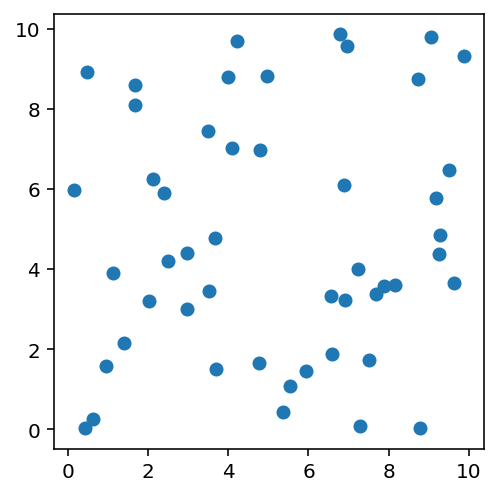

In [9]:
gdf.plot()

## Create the Distances Matrix

In [10]:
distances = np.zeros((len(gdf),len(gdf)))
for i,row in gdf.iterrows():
    for j,row2 in gdf.iterrows():
        distances[j,i] = row.geometry.distance(row2.geometry)

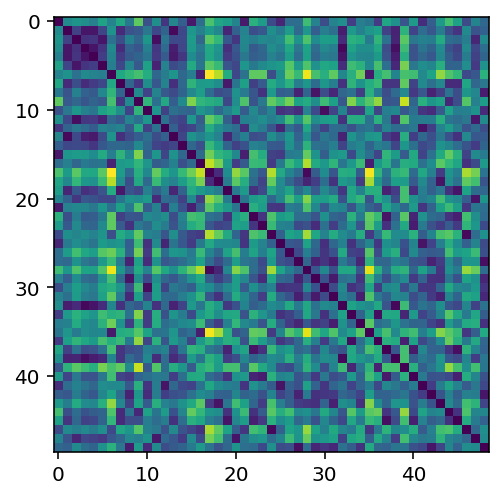

In [11]:
plt.imshow(distances)

# **SETTING UP THE OPTIMIZATION MODEL**

## Set up the model

In [12]:
solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
model = pywraplp.Solver("Uncapacitated Fixed Charge", solver_instance)

## Set up model constants

In [13]:
cij = distances

In [14]:
n_customers = cij.shape[0]
range_customers = range(n_customers)

In [15]:
n_facilityCandidates = cij.shape[1]
range_facilityCandidates = range(n_facilityCandidates)

In [16]:
demands = np.array(gdf["demand"])
demands_sum = demands.sum()

In [17]:
cost_construction = np.array(gdf["fixed cost"])

In [18]:
distance_demands = np.multiply(demands,cij)

## Set up the Objective Function and Decision Variables

In [19]:
alpha = 75.0

Relaxed Objective Function
$$min(\sum_{j=0} f_jx_j +\sum_{j=0} \sum_{i=0} (\alpha d_{ij} h_i-u_i)y_{ij} + \sum_{i=0}u_i)$$

## Set up the Constraints

Constraint 1: Customers can only be served by open facilities
$$y_{ij} \leq x_j, \forall_{i,j}$$

Constraint 2: Every customer goes to one facility for service
$$\sum_{j}y_{i,j}=1,\forall_{i,j}\to RELAX$$

Constraint 3: Facilities are binary
$$x_j \in \{0,1\}, \forall_{j}$$

In [ ]:
# set in model definition

Constraint 1: Customer service allocations are binary
$$y_{i,j} \in \{0,1\}, \forall_{i,j}$$

In [ ]:
# set in model definition

# **TRY SOLVING THE NP-HARD PROBLEM**

In [122]:
def solveOriginal(alpha=75):
    model = pywraplp.Solver("Uncapacitated Fixed Charge", solver_instance)
    fac_vars = {j: model.IntVar(0,1, 'y[%i]' % (j)) for j in range_facilityCandidates}
    cli_vars = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates}
    obj = [cost_construction[j] * fac_vars[j] + alpha * distance_demands[i,j] * cli_vars[i,j] for i in range_customers for j in range_facilityCandidates]
#     obj = [cost_construction[j] * fac_vars[j] + alpha * distances[i,j] * demands[i] * cli_vars[i,j] for i in range_customers for j in range_facilityCandidates]
#     obj = model.Sum([cost_construction[j] * fac_vars[j] for j in range_facilityCandidates]) + model.Sum([alpha * distance_demands[i,j] * cli_vars[i,j] for i in range_customers for j in range_facilityCandidates])

    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(fac_vars[j] - cli_vars[i,j] >= 0) 
#             model.Add(fac_vars[j] >= cli_vars[i,j])
    for i in range_customers:
        model.Add(model.Sum([cli_vars[i,j] for j in range_facilityCandidates]) == 1)
    model.Minimize(model.Sum(obj))
#     model.Minimize(obj)
    model.Solve()
    resultGDF = gdf.copy(deep=True)
    resultGDF["Status"] = [fac_vars[j].solution_value() for j in range_facilityCandidates]
    
    return model,fac_vars,cli_vars,resultGDF

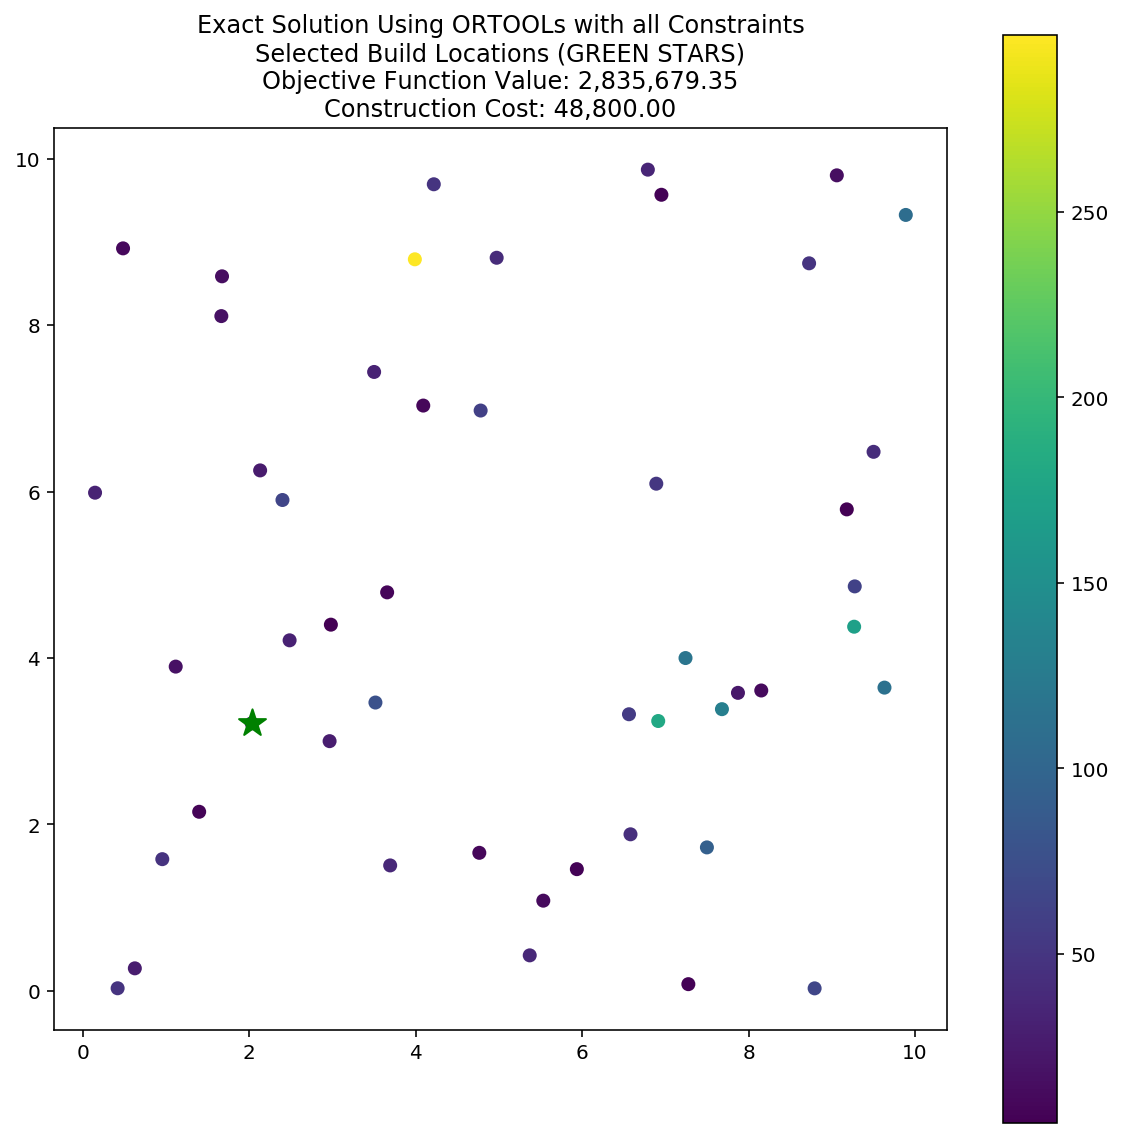

In [123]:
m,f,c,g = solveOriginal(alpha=75.0)
fig,ax = plt.subplots(figsize=(10,10))
g.plot("demand",legend=True,ax=ax)
g[g["Status"]==1].plot(marker='*',markersize=200,color='green',ax=ax)
constructionCost = np.sum(cost_construction * np.array([a.solution_value() for a in f.values()]))
penaltyCost = 0
ax.set_title(f"Exact Solution Using ORTOOLs with all Constraints\nSelected Build Locations (GREEN STARS)\nObjective Function Value: {m.Objective().Value():,.2f}\nConstruction Cost: {constructionCost:,.2f}");

In [ ]:
for k,v in c.items():
    print(v.solution_value())

Relaxed Objective Function
$$min(\sum_{j=0} f_jx_j +\sum_{j=0} \sum_{i=0} (\alpha d_{ij} h_i-u_i)y_{ij} + \sum_{i=0}u_i)$$

In [155]:
def solveRelaxed(u_vars):
    alpha = 75
    model = pywraplp.Solver("Uncapacitated Fixed Charge", solver_instance)
    fac_vars = {j: model.IntVar(0,1, 'y[%i]' % (j)) for j in range_facilityCandidates}
    cli_vars = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates}
#     obj = [cost_construction[j] * fac_vars[j] + 
#        (alpha * distance_demands[i,j] - u_vars[i]) * cli_vars[i,j] +
#        u_vars[i]
#        for i in range_customers 
#        for j in range_facilityCandidates]
#     obj = model.Sum([cost_construction[j] * fac_vars[j] for j in range_facilityCandidates]) + alpha * model.Sum([(distance_demands[i,j]-u_vars[i])*cli_vars[i,j] for i in range_customers for j in range_facilityCandidates]) + model.Sum([u_vars[i] * (1 - model.Sum([cli_vars[i,j] for j in range_facilityCandidates])) for i in range_customers]) 
#     obj = [cost_construction[j] * fac_vars[j] + 
#            alpha * distance_demands[i,j] * cli_vars[i,j] + 
#            u_vars[i] * (1 - [cli_vars[i,j] for j in range_facilityCandidates])) 
#            for i in range_customers 
#            for j in range_facilityCandidates]
#     obj = model.Sum([cost_construction[j] * fac_vars[j] for j in range_facilityCandidates]) + model.Sum([(alpha * distance_demands[i,j] - u_vars[i])* cli_vars[i,j] for i in range_customers for j in range_facilityCandidates]) + model.Sum([u_vars[i] for i in range_customers])
    obj = model.Sum([cost_construction[j] * fac_vars[j] for j in range_facilityCandidates]) + alpha * model.Sum([distance_demands[i,j] * cli_vars[i,j] for i in range_customers for j in range_facilityCandidates]) + model.Sum([u_vars[i] * (1 - model.Sum([cli_vars[i,j] for j in range_facilityCandidates])) for i in range_customers])

#     for i in range_customers:
#         model.Add(model.Sum([cli_vars[i,j] for j in range_facilityCandidates]) == 1)
    
    for i in range_customers:
        for j in range_facilityCandidates:
            #model.Add(cli_vars[i,j] <= fac_vars[j])
            model.Add(fac_vars[j] - cli_vars[i,j] >= 0) 
#     model.Minimize(model.Sum(obj))
    model.Minimize(obj)
    model.Solve()
    resultGDF = gdf.copy(deep=True)
    resultGDF["Status"] = [fac_vars[j].solution_value() for j in range_facilityCandidates]
    
    return model,fac_vars,cli_vars,resultGDF

In [158]:
u_vars = np.array([4500 for i in range_customers])

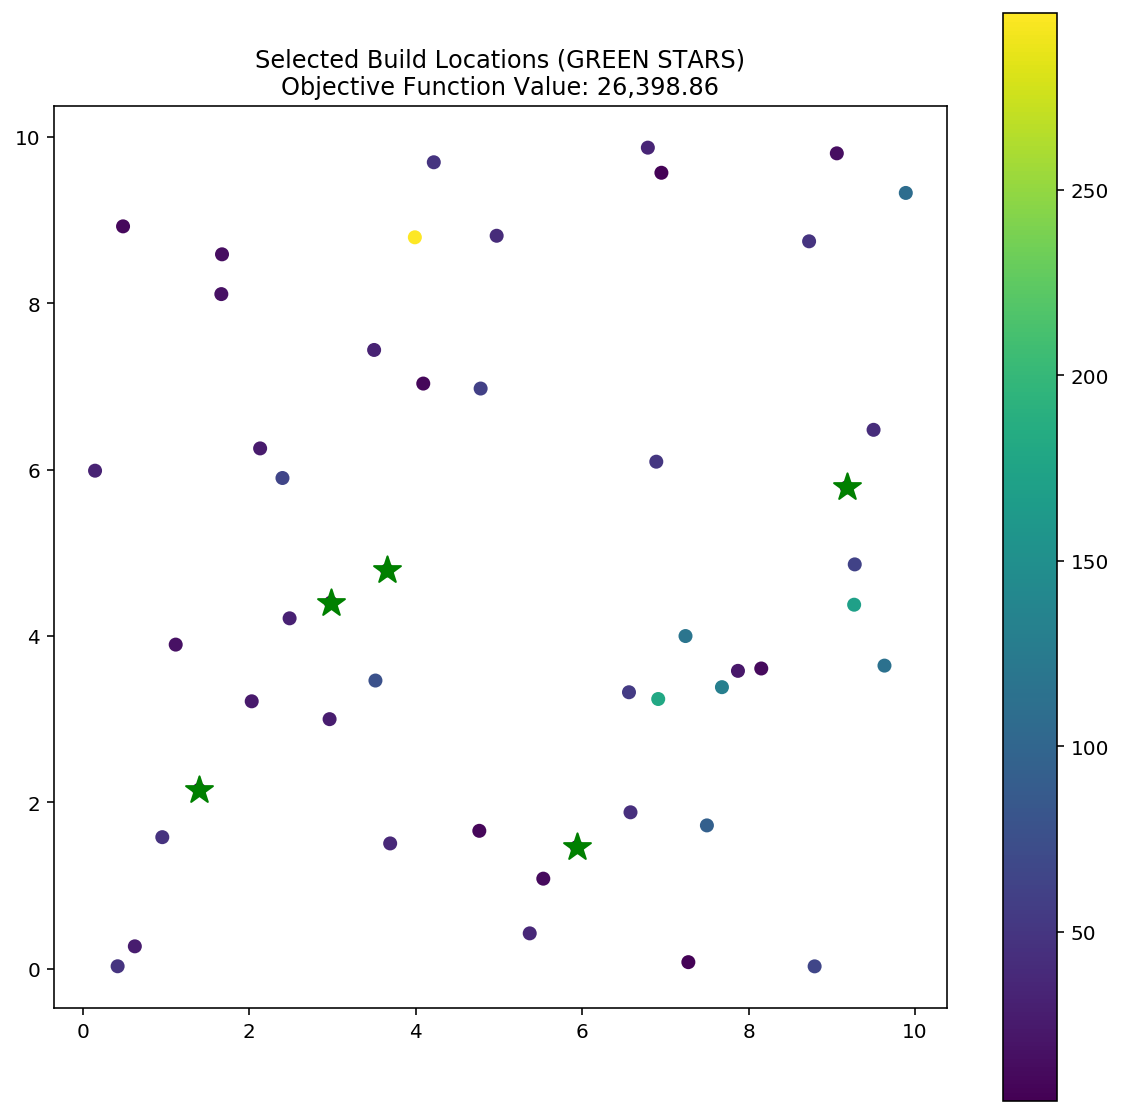

In [159]:
m,f,c,g = solveRelaxed(u_vars)
fig,ax = plt.subplots(figsize=(10,10))
g.plot("demand",legend=True,ax=ax)
g[g["Status"]==1].plot(marker='*',markersize=200,color='green',ax=ax)
ax.set_title(f"Selected Build Locations (GREEN STARS)\nObjective Function Value: {m.Objective().Value():,.2f}");

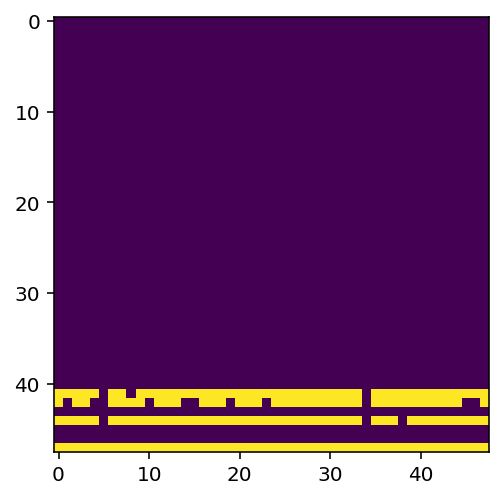

In [33]:
customerResults = np.zeros((j,i))
for i in range_customers:
    for j in range_facilityCandidates:
        customerResults[j-1,i-1] = c[i,j].solution_value()
plt.imshow(customerResults)

# **LAGRANGIAN RELAXATION**

In [34]:
step = 0
t = 2.0
lambdaK = 2.0
u_vars = np.array([65000 for i in range_customers])

$$ u_i^{k+1} = max\{ 0,u_i^k - t^k(b_i - \sum_j a_{i,j}x_j^k) \} $$

In [73]:
def updateUVars(u_vars,t,x_vars,usingORTools=True):
    t = 1 # KLUDGE!
    new_u = []
    i = 0
    for u in u_vars:
        if usingORTools:
            interiorSum = np.sum([x_vars[i,j].solution_value() for j in range_facilityCandidates])
        else:
            interiorSum = np.sum([x_vars[i,j] for j in range_facilityCandidates])
#         next_u = u-t*(1.0-interiorSum)
        # Kludge
        next_u = u - t * np.power(1-interiorSum,2)
        if next_u < 0:
            next_u = 0.0
        new_u.append(next_u)
        i += 1
    u_vars_updated = np.array(new_u)
    return u_vars_updated

$$ t^k=\frac{\lambda^k (z_D(u^k)-z^{LB})}{ \sum_{i=1}^m (b_i - \sum_{j=1}^n a_{i,j}x_j^k)^2 } $$

In [36]:
kludge_denominators = []

In [37]:
def updateStepSize(xvars,lambdaK,zd,zlb=0,usingORTools=True):
    numerator = lambdaK * (zd-zlb)
    denominator = 0.0
    for i in range_customers:
        b = 1.0
        interior = 0.0
        for j in range_facilityCandidates:
            if usingORTools:
                interior += xvars[i,j].solution_value()
            else:
                interior += xvars[i,j]
        denominator += np.power(b-interior,2) 
#         print(f"b:{b},interior:{interior}")
    if denominator == 0:
        denominator = 0.000000001
#         denominator = 999999999999999999999
    tk = numerator / denominator
    # kludge
    tk = denominator * lambdaK
    kludge_denominators.append(denominator)
    return tk

In [38]:
def setx(cost_construction,distance_demands,uvars,alpha=75.0):
    newXs = []
    for j in range(0,len(range_facilityCandidates)):
        vi = cost_construction[j]
        for i in range(0,len(range_customers)):
            term = alpha * distance_demands[i,j] - uvars[i]
            #print(term)
            if term > 0:
                term = 0
            vi += term
        if vi < 0:
            newXs.append(1)
        else:
            newXs.append(0)
#         print(vi)
    return newXs

In [39]:
def sety(xvars,distance_demands,uvars,alpha=75.0):
    newYs = []
    yMat = np.zeros((len(gdf),len(gdf)))
    for i in range_customers:
        for j in range_facilityCandidates:
            xvar = xvars[j]
            term = alpha * distance_demands[i,j] - uvars[i]
            if xvar == 1 and term < 0:
                newYs.append(1)
                yMat[i,j] = 1
            else:
                newYs.append(0)
    return yMat

In [40]:
u_vars = [4500 for i in range_facilityCandidates]

In [41]:
xx = setx(cost_construction,distance_demands,u_vars)
yy = sety(xx,distance_demands,u_vars)

In [42]:
u_vars = np.array([65000.0 for i in range_customers])
m,f,c,g = solveRelaxed(u_vars)

In [43]:
tk = updateStepSize(c,lambdaK,m.Objective().Value())

In [44]:
def isSolutionFeasible(cli_vars,fac_vars):
    obj = 0.0
    for j in range_facilityCandidates:
        obj += cost_construction[j] * fac_vars[j].solution_value()
    for i in range_customers:
        for j in range_facilityCandidates:
            obj += alpha * distance_demands[i,j] * cli_vars[i,j].solution_value()
    isFeasible = True
    for j in range_facilityCandidates:
        for i in range_customers:
            if cli_vars[i,j].solution_value() > fac_vars[j].solution_value():
                isFeasible = False
    for i in range_customers:
        summation = 0.0
        for j in range_facilityCandidates:
            summation += cli_vars[i,j].solution_value()
        if summation != 1:
            isFeasible = False
    return obj,isFeasible

In [45]:
def isSolutionFeasible_Manual(cli_vars,fac_vars):
    obj = 0.0
    for j in range_facilityCandidates:
        obj += cost_construction[j] * fac_vars[j]
    constructionIndex = -1
    for i in range_customers:
        for j in range_facilityCandidates:
            constructionIndex += 1
            obj += alpha * distance_demands[i,j] * cli_vars[i,j]
    isFeasible = True
    constructionIndex = -1
    for j in range_facilityCandidates:
        for i in range_customers:
            constructionIndex += 1
            if cli_vars[i,j] > fac_vars[j]:
                isFeasible = False
    constructionIndex = -1
    for i in range_customers:
        summation = 0.0
        for j in range_facilityCandidates:
            constructionIndex += 1
            summation += cli_vars[i,j]
        if summation != 1:
            isFeasible = False
    return obj,isFeasible

In [46]:
isSolutionFeasible_Manual(yy,xx)

(876898.8637546119, False)

In [109]:
def generateFeasibleSolution(g):
    # assign each customer to the nearest facility
    nearestOpenFacilities = []
    nearestOpenFacilitiesDistances = []
    g_openForBusiness = g[g["Status"]==1]
    for i,row in g.iterrows():
        nearestOpenFacility = None
        nearestOpenFacilityDistance = 100
        for j,facRow in g_openForBusiness.iterrows():
            distance = row.geometry.distance(facRow.geometry)
            if distance < nearestOpenFacilityDistance:
                nearestOpenFacility = j
                nearestOpenFacilityDistance = distance
        nearestOpenFacilities.append(nearestOpenFacility)
        nearestOpenFacilitiesDistances.append(nearestOpenFacilityDistance)
    g["Service Facility"] = nearestOpenFacilities
    g["Service Distance"] = nearestOpenFacilitiesDistances
    zs = np.sum(alpha * g["demand"] * g["Service Distance"]) + np.sum(g_openForBusiness["fixed cost"])
    return g, zs

Step 0: tk = 1474.0, Objective: 26,398.86, Feasible: False, Building 5 facilities, True Objective: 876,898.86, Feasible Score: 801,840.66
Step 1: tk = 1474.0, Objective: 29,293.86, Feasible: False, Building 5 facilities, True Objective: 876,898.86, Feasible Score: 801,840.66
New LAMBDAK: 1.0
Step 2: tk = 730.0, Objective: 32,173.79, Feasible: False, Building 5 facilities, True Objective: 872,415.79, Feasible Score: 801,840.66
Step 3: tk = 730.0, Objective: 35,031.79, Feasible: False, Building 5 facilities, True Objective: 872,415.79, Feasible Score: 801,840.66
New LAMBDAK: 0.5
Step 4: tk = 365.0, Objective: 37,889.79, Feasible: False, Building 5 facilities, True Objective: 872,415.79, Feasible Score: 801,840.66
New LAMBDAK: 0.25
Step 5: tk = 179.0, Objective: 40,736.84, Feasible: False, Building 5 facilities, True Objective: 863,564.84, Feasible Score: 801,840.66
Step 6: tk = 179.0, Objective: 43,520.84, Feasible: False, Building 5 facilities, True Objective: 863,564.84, Feasible Score

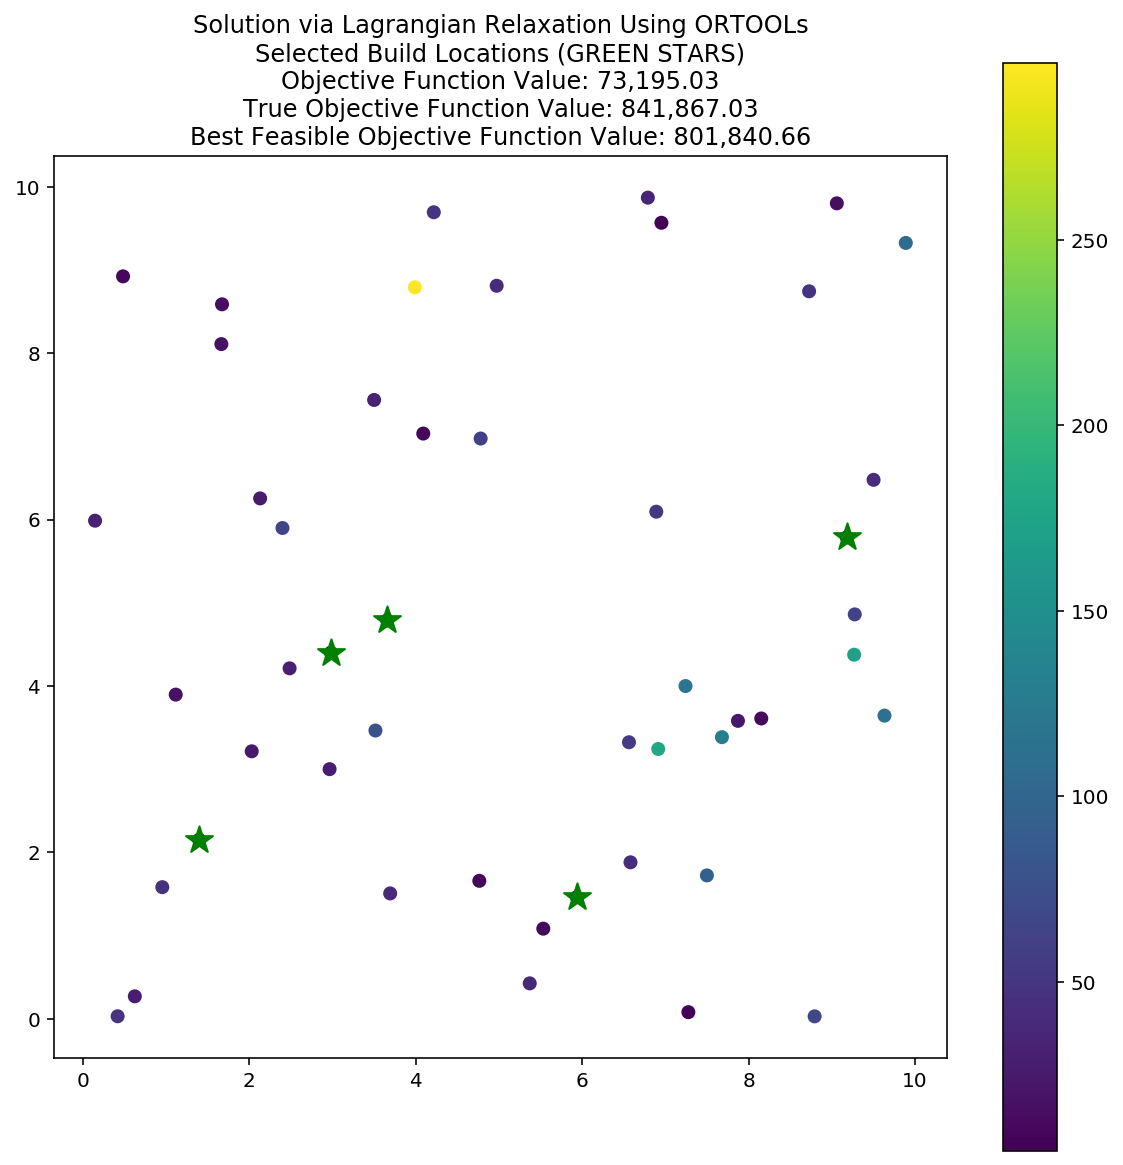

In [169]:
startTime = dt.datetime.now()
objValues = []
list_of_u_vars = []
lambdaK = 2.0
u_vars = np.array([4500 for i in range_customers])
step = 0
zlb = 10000000000000000
while step < 91:
    list_of_u_vars.append(u_vars)
    #print(u_vars)
    m,f,c,g = solveRelaxed(u_vars)
    g,zlb = generateFeasibleSolution(g)
    feasibleG,feasibleBestScore = generateFeasibleSolution(g)
    nFacilities = len(g[g["Status"]==1])
    # check feasibility
    zs,isFeasible = isSolutionFeasible(c,f)
    if zs < zlb and isFeasible:
        zlb = zlb
        print(f"New lower bound found: {zlb}")
#     tk = updateStepSize(c,lambdaK,m.Objective().Value(),zlb=zlb)
    tk = updateStepSize(c,lambdaK,zs,zlb=zlb)
    print(f"Step {step}: tk = {tk}, Objective: {m.Objective().Value():,.2f}, Feasible: {isFeasible}, Building {nFacilities} facilities, True Objective: {zs:,.2f}, Feasible Score: {feasibleBestScore:,.2f}")
    u_vars = updateUVars(u_vars,tk,c)
#     u_vars = [u_var + 500 for u_var in u_vars]
    #print(u_vars)
#     objValues.append(m.Objective().Value())
    objValues.append(zs)
    if step > 0:
        if np.isclose(objValues[step-1],objValues[step]):
            lambdaK /= 2.0
            print(f"New LAMBDAK: {lambdaK}")
            if lambdaK < 0.001:
                break
    if np.isclose(m.Objective().Value(),zs):
        print("SOLUTION FOUND!!!!")
#         break
    step += 1
fig,ax = plt.subplots(figsize=(10,10))
g.plot("demand",legend=True,ax=ax)
g[g["Status"]==1].plot(marker='*',markersize=200,color='green',ax=ax)
ax.set_title(f"Solution via Lagrangian Relaxation Using ORTOOLs\nSelected Build Locations (GREEN STARS)\nObjective Function Value: {m.Objective().Value():,.2f}\nTrue Objective Function Value: {zs:,.2f}\nBest Feasible Objective Function Value: {feasibleBestScore:,.2f}")
endTime = dt.datetime.now();
print(f"Completed in {(endTime-startTime).total_seconds()} seconds")

Step 0: tk = 1474.0, Objective: 876898.8637546119, Feasible: False, Building 5 facilities, True Objective: 876,898.86, Best Feasible: 801,840.66
Step 1: tk = 1474.0, Objective: 876898.8637546119, Feasible: False, Building 5 facilities, True Objective: 876,898.86, Best Feasible: 801,840.66
New LAMBDAK: 1.0
Step 2: tk = 730.0, Objective: 872415.794184836, Feasible: False, Building 5 facilities, True Objective: 872,415.79, Best Feasible: 801,840.66
New LAMBDAK: 0.5
Step 3: tk = 365.0, Objective: 872415.794184836, Feasible: False, Building 5 facilities, True Objective: 872,415.79, Best Feasible: 801,840.66
New LAMBDAK: 0.25
Step 4: tk = 182.5, Objective: 872415.794184836, Feasible: False, Building 5 facilities, True Objective: 872,415.79, Best Feasible: 801,840.66
New LAMBDAK: 0.125
Step 5: tk = 89.5, Objective: 863564.8438182964, Feasible: False, Building 5 facilities, True Objective: 863,564.84, Best Feasible: 801,840.66
New LAMBDAK: 0.0625
Step 6: tk = 44.75, Objective: 863564.843818296

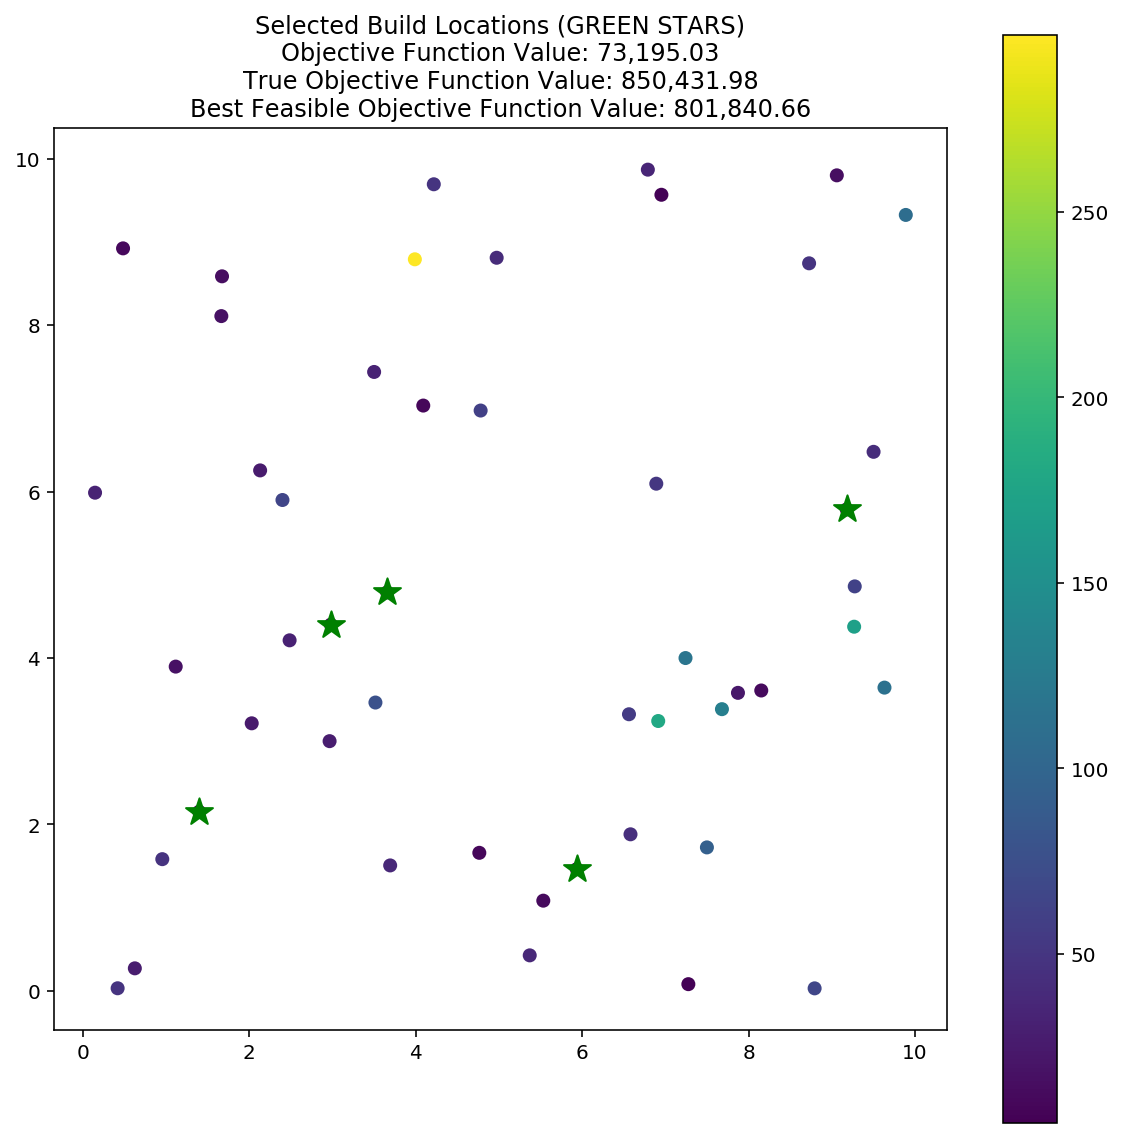

In [178]:
# without OR Tools
startTime = dt.datetime.now()
objValues = []
list_of_u_vars = []
lambdaK = 2.0
u_vars = np.array([4500 for i in range_customers])
step = 0
zlb = 10000000000000000
iterations = []
bestUpperBounds = []
bestLowerBounds = []
while step < 91:
    alpha=75.0
    list_of_u_vars.append(u_vars)
    f = setx(cost_construction,distance_demands,u_vars)
    c = sety(xx,distance_demands,u_vars)
    zs,isFeasible = isSolutionFeasible_Manual(c,f)
    
    g = gdf.copy(deep=True)
    g["Status"] = [f[j] for j in range_facilityCandidates]
    feasibleG,feasibleBestScore = generateFeasibleSolution(g)

    
    if zs < zlb and isFeasible:
        zlb = zlb
        print(f"New lower bound found: {zlb}")
    tk = updateStepSize(c,lambdaK,zs,zlb=zlb,usingORTools=False)
    nFacilities = np.sum(f)
    if step % 50 == 0 or True:
        print(f"Step {step}: tk = {tk}, Objective: {zs}, Feasible: {isFeasible}, Building {nFacilities} facilities, True Objective: {zs:,.2f}, Best Feasible: {feasibleBestScore:,.2f}")
    u_vars = updateUVars(u_vars,tk,c,usingORTools=False)
#     u_vars = [u_var + 500 for u_var in u_vars]
    objValues.append(m.Objective().Value())
    if step > 0:
        if np.isclose(objValues[step-1],objValues[step]):
            lambdaK /= 2.0
            print(f"New LAMBDAK: {lambdaK}")
            if lambdaK < 0.001:
                break
    if np.isclose(zs,zlb):
        print("SOLUTION FOUND!!!!")
    iterations.append(step)
    bestUpperBounds.append(zs)
    bestLowerBounds.append(feasibleBestScore)
    step += 1
g = gdf.copy(deep=True)
g["Status"] = [f[j] for j in range_facilityCandidates]
feasibleG,feasibleBestScore = generateFeasibleSolution(g)

fig,ax = plt.subplots(figsize=(10,10))
g.plot("demand",legend=True,ax=ax)
g[g["Status"]==1].plot(marker='*',markersize=200,color='green',ax=ax)
ax.set_title(f"Selected Build Locations (GREEN STARS)\nObjective Function Value: {m.Objective().Value():,.2f}\nTrue Objective Function Value: {zs:,.2f}\nBest Feasible Objective Function Value: {feasibleBestScore:,.2f}");
endTime = dt.datetime.now()
print(f"Completed in {(endTime-startTime).total_seconds()} seconds")

Text(0, 0.5, 'Objective Function Value')

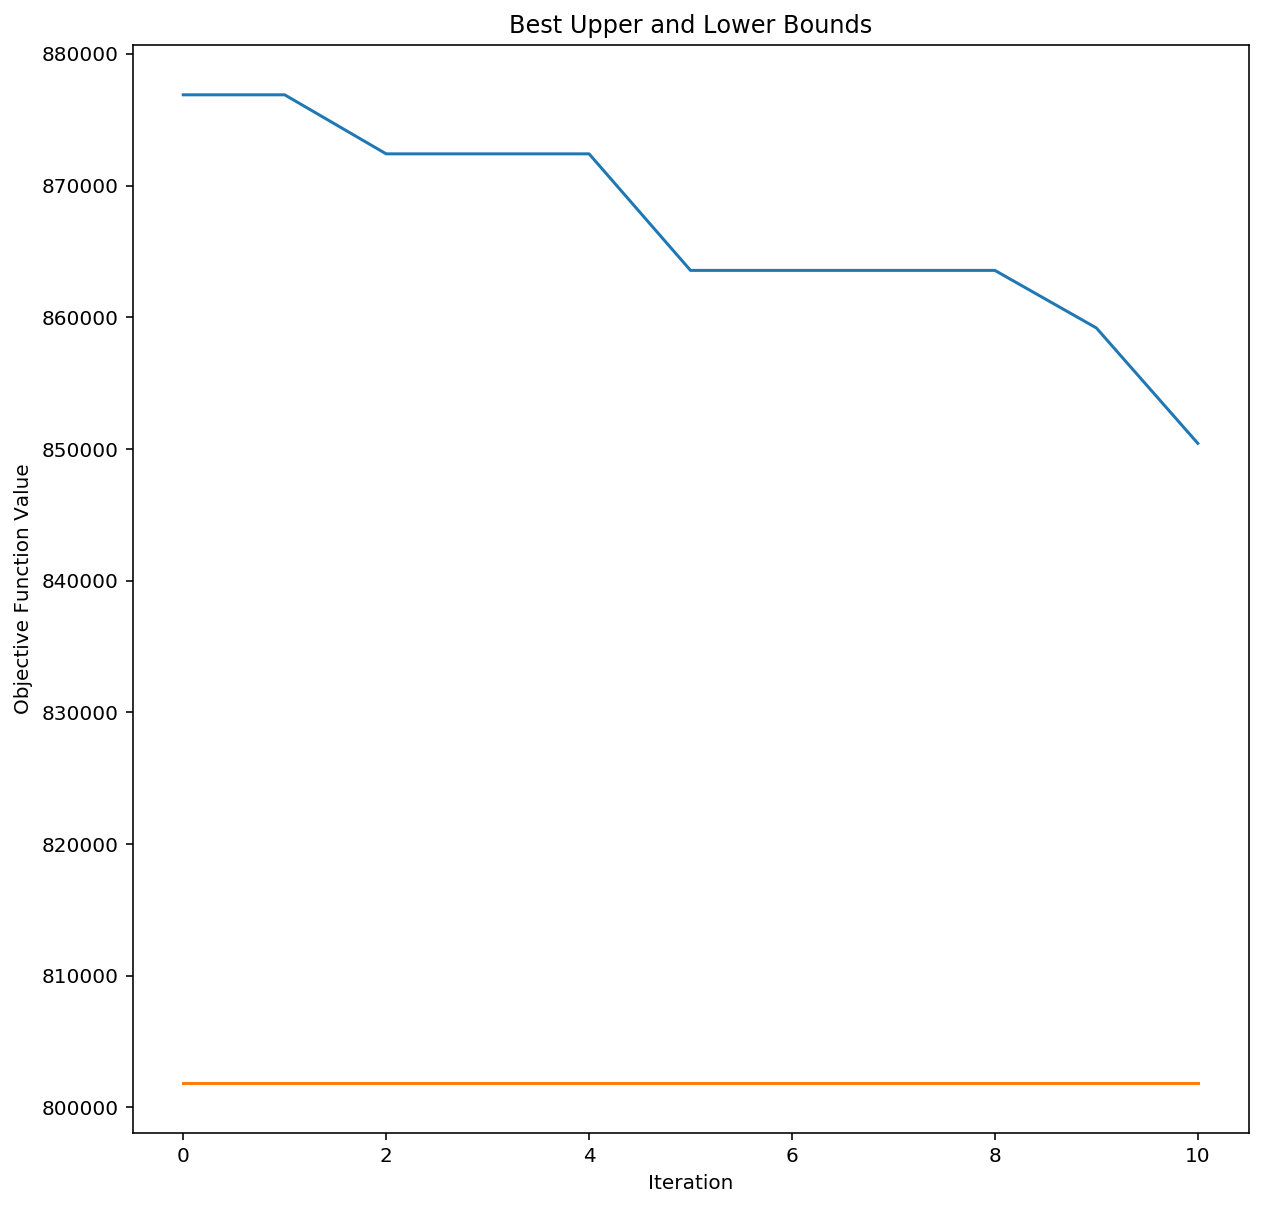

In [181]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(iterations,bestUpperBounds,ax=ax)
sns.lineplot(iterations,bestLowerBounds,ax=ax)
ax.set_title("Best Upper and Lower Bounds")
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective Function Value")

In [108]:
feasibleG

,demand,fixed cost,x-coor,y-coor,geometry,Status,Service Facility,Service Distance
0,297.60021,115800,3.990689,8.790538,POINT (3.990688779742229 8.79053837885956),0,48,4.504583
1,179.90455,101800,6.914889,3.242761,POINT (6.914889470625136 3.242761009463191),0,48,4.100120
2,169.86510,72600,9.269144,4.375885,POINT (9.26914393799785 4.375885076886723),0,48,6.287593
3,129.37926,72400,7.680610,3.385106,POINT (7.680610104506709 3.385106360386922),0,48,4.807452
4,118.81643,38400,7.242835,3.999340,POINT (7.242835359965627 3.99934022242272),0,48,4.280071
5,114.30602,59200,9.633594,3.644005,POINT (9.633594413536645 3.64400534339846),0,48,6.694866
6,108.47115,66000,9.889748,9.323627,POINT (9.889747516273976 9.323627326725621),0,48,8.482943
7,92.95297,48400,7.500000,1.724000,POINT (7.5 1.723999981781059),0,48,5.251595
8,77.30188,71300,3.517091,3.464686,POINT (3.517091071782172 3.464685972715098),0,48,1.078137
9,66.28637,96600,8.794208,0.030382,POINT (8.794208034977842 0.03038151738391726),0,48,7.272124


In [175]:
g[g["Status"]==1]

,demand,fixed cost,x-coor,y-coor,geometry,Status,Service Facility,Service Distance
42,7.99065,63200,3.657741,4.788645,POINT (3.657741103281649 4.788645329071864),1,42,0.0
43,6.96004,59500,1.399047,2.152038,POINT (1.399046814770006 2.1520378562325),1,43,0.0
45,6.38800,67900,5.937211,1.462666,POINT (5.937211016771203 1.462665709977014),1,45,0.0
47,5.62758,94100,9.180702,5.785650,POINT (9.180701800220685 5.785649967350048),1,47,0.0
48,4.53588,68700,2.981599,4.400436,POINT (2.98159934482463 4.40043552269411),1,48,0.0


In [77]:
list_of_u_vars

[array([4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500,
        4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500,
        4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500,
        4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500,
        4500, 4500, 4500, 4500, 4500]),
 array([4484., 4484., 4484., 4484., 4484., 4484., 4496., 4484., 4484.,
        4484., 4484., 4484., 4484., 4484., 4484., 4484., 4491., 4484.,
        4484., 4484., 4491., 4484., 4484., 4484., 4491., 4484., 4484.,
        4484., 4484., 4484., 4484., 4484., 4484., 4484., 4484., 4491.,
        4484., 4484., 4484., 4484., 4484., 4484., 4484., 4484., 4484.,
        4484., 4491., 4484., 4484.]),
 array([4468., 4468., 4468., 4468., 4468., 4468., 4492., 4468., 4468.,
        4468., 4468., 4468., 4468., 4468., 4468., 4468., 4482., 4468.,
        4468., 4468., 4482., 4468., 4468., 4468., 4482., 4468., 4468.,
        4468., 4468., 4468., 4468., 4468., 4468., 4468., 4

## SOLVE

In [ ]:
%%time
model.Minimize(model.Sum(obj))

In [ ]:
%%time
model.Solve()

In [ ]:
model.Objective().Value()

In [ ]:
model.constraints()

In [ ]:
model.WallTime() * 1.66667e-5

In [ ]:
lp_formulation = model.ExportModelAsLpFormat(True)

In [ ]:
fac2iloc = {v.name():k for k,v in fac_vars.items()}

In [ ]:
customerResults = np.zeros((j,i))

In [ ]:
for i in range_customers:
    for j in range_facilityCandidates:
        customerResults[j-1,i-1] = cli_vars[i,j].solution_value()

In [ ]:
plt.imshow(customerResults)

In [ ]:
for j in range_facilityCandidates:
    print(fac_vars[j].solution_value())

# **REFERENCES**

Objective Function
$$min(\sum_{j=0} f_jx_j +\alpha\sum_{j=0} \sum_{i=0} d_{ij} h_i)$$

In [ ]:
obj = [cost_construction * fac_vars[j] + alpha * distance_demands[i,j] for i in range_customers for j in range_facilityCandidates]

Relaxed Objective Function
$$min(\sum_{j=0} f_jx_j +\sum_{j=0} \sum_{i=0} (\alpha d_{ij} h_i-u_i)y_{ij} + \sum_{i=0}u_i)$$

In [ ]:
u_vars[i]

In [ ]:
u_vars[i] * cli_vars[i,j]

In [ ]:
alpha * distance_demands[i,j] * cli_vars[i,j] - u_vars[i] * cli_vars[i,j]

In [ ]:
(alpha * distance_demands[i,j] - u_vars[i]) * cli_vars[i,j]

In [ ]:
obj = [cost_construction * fac_vars[j] + (alpha * distance_demands[i,j] - u_vars[i]) * cli_vars[i,j] for i in range_customers for j in range_facilityCandidates]